# Time series: motif and shaplet

Motif: a repeated pattern in the time series.
We can discover motif by computing the Matrix Profile: a data structure that annotates time series by using a sliding window to compare the pairwise distance among the subsequences.

### Matrix Profile
You can use these packages:
    
    
https://github.com/target/matrixprofile-ts

https://github.com/TDAmeritrade/stumpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matrixprofile import *

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('./datasets/AirPassengers.csv', parse_dates=True, index_col='Month', date_parser=dateparse)
df.head()

C:\Users\Utente\AppData\Local\Temp\ipykernel_24340\3314540588.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


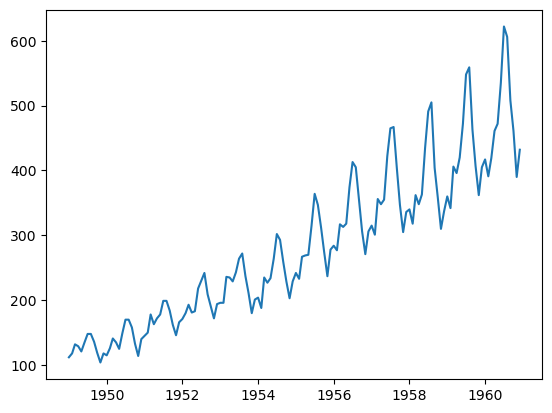

In [3]:
ts = df['#Passengers']
plt.plot(ts)
plt.show()

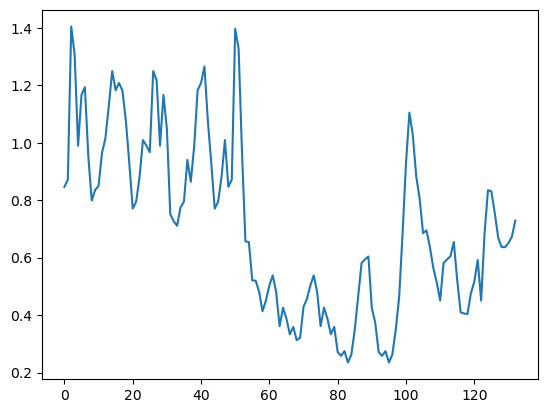

In [4]:
w = 12
mp, mpi = matrixProfile.stomp(ts.values, w)

plt.plot(mp)
plt.show()

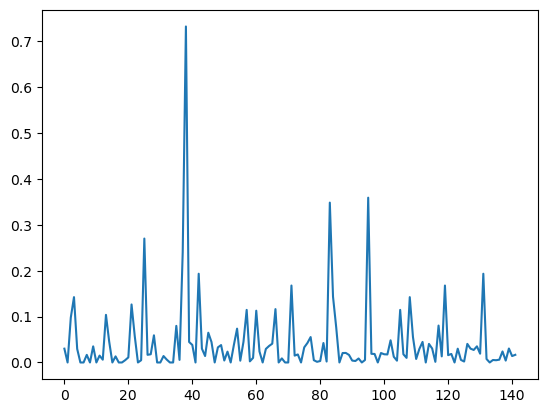

In [5]:
w = 3
mp, mpi = matrixProfile.stomp(ts.values, w)

plt.plot(mp)
plt.show()

### Motif discovery
Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.


The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [6]:
mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=5)

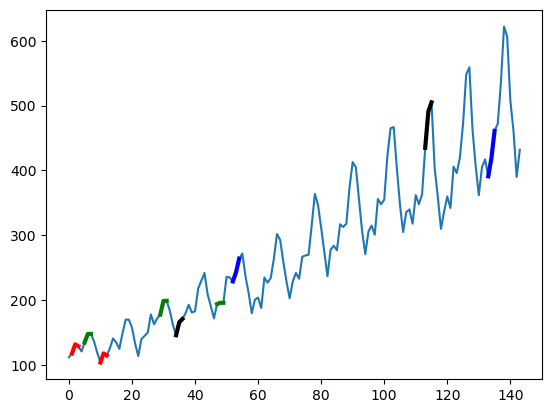

In [7]:
plt.plot(ts.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

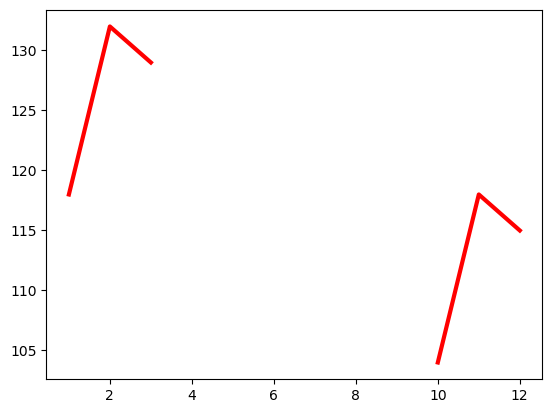

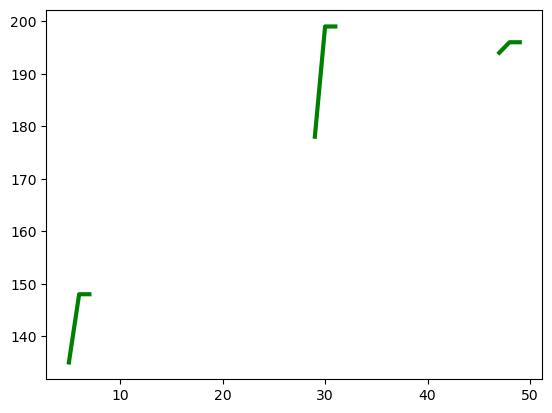

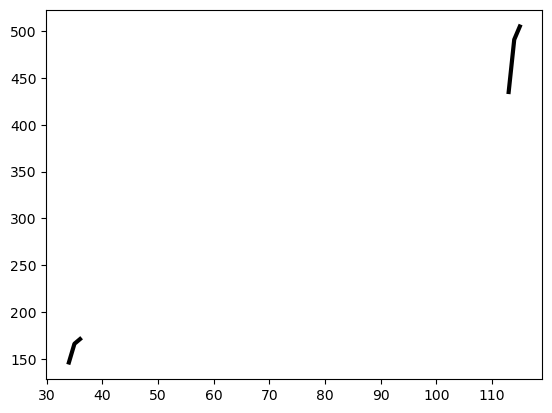

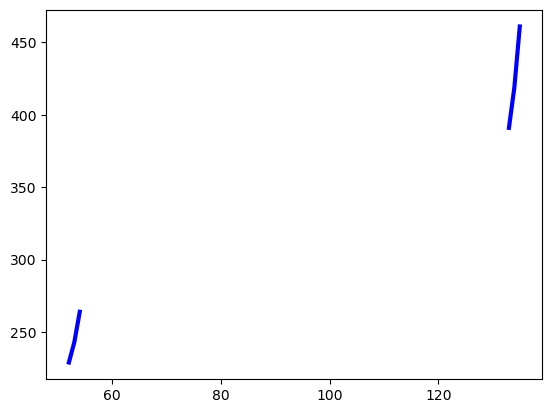

In [8]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

### Anomaly Discovery
Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord   


Returns a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [10]:
from matrixprofile.discords import discords
anoms = discords(mp, ex_zone=3, k=5)

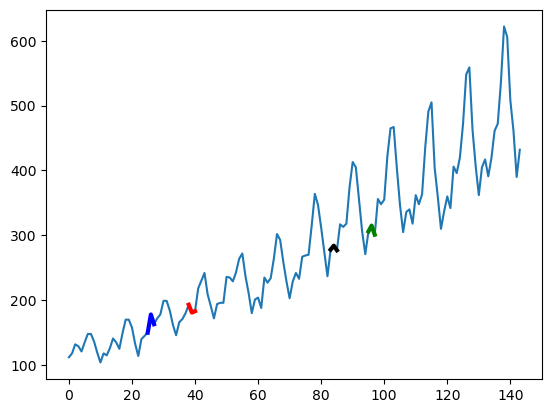

In [11]:
plt.plot(ts.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

### Shaplet discovery

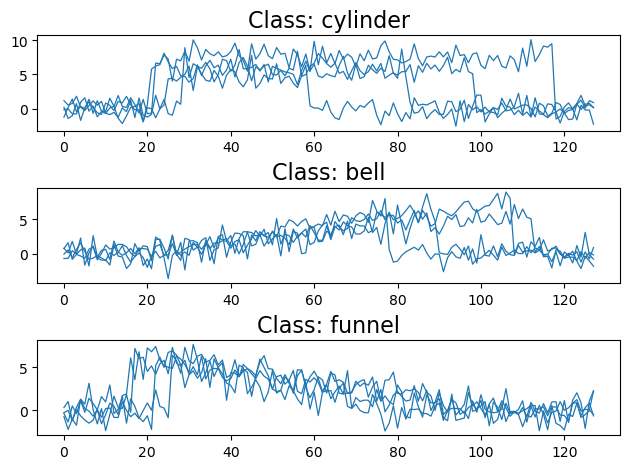

In [13]:
from pyts.datasets import make_cylinder_bell_funnel

X, y = make_cylinder_bell_funnel(n_samples=12, random_state=42)

plt.figure()
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

In [14]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

In [15]:
# Compute number and length of shapelets.
# l: Fraction of the length of time series to be used for base shapelet length
# r: Number of different shapelet lengths to use

# return: Dictionary giving, for each shapelet length, the number of such shapelets to be generated

In [16]:
n_ts, ts_sz = X.shape
n_classes = len(set(y))


shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 12
ts_sz 128
n_classes 3
shapelet_sizes {12: 3}


In [17]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

C:\Users\Utente\anaconda3\envs\phd\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [18]:
shp_clf.fit(X, y)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.1411 - categorical_accuracy: 0.4167 - categorical_crossentropy: 1.1248
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 1.1190 - categorical_accuracy: 0.4167 - categorical_crossentropy: 1.1027
Epoch 3/200
1/1 [==============================] - 0s 13ms/step - loss: 1.0984 - categorical_accuracy: 0.4167 - categorical_crossentropy: 1.0821
Epoch 4/200
1/1 [==============================] - 0s 13ms/step - loss: 1.0793 - categorical_accuracy: 0.4167 - categorical_crossentropy: 1.0630
Epoch 5/200
1/1 [==============================] - 0s 15ms/step - loss: 1.0617 - categorical_accuracy: 0.5000 - categorical_crossentropy: 1.0454
Epoch 6/200
1/1 [==============================] - 0s 18ms/step - loss: 1.0454 - categorical_accuracy: 0.5833 - categorical_crossentropy: 1.0291
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 1.0305 - categorical_accuracy: 0.5833 - categorical_crossent

1/1 [==============================] - 0s 11ms/step - loss: 0.8416 - categorical_accuracy: 0.6667 - categorical_crossentropy: 0.8243
Epoch 58/200
1/1 [==============================] - 0s 11ms/step - loss: 0.8406 - categorical_accuracy: 0.6667 - categorical_crossentropy: 0.8234
Epoch 59/200
1/1 [==============================] - 0s 10ms/step - loss: 0.8397 - categorical_accuracy: 0.6667 - categorical_crossentropy: 0.8225
Epoch 60/200
1/1 [==============================] - 0s 12ms/step - loss: 0.8388 - categorical_accuracy: 0.6667 - categorical_crossentropy: 0.8216
Epoch 61/200
1/1 [==============================] - 0s 11ms/step - loss: 0.8380 - categorical_accuracy: 0.6667 - categorical_crossentropy: 0.8207
Epoch 62/200
1/1 [==============================] - 0s 12ms/step - loss: 0.8371 - categorical_accuracy: 0.7500 - categorical_crossentropy: 0.8198
Epoch 63/200
1/1 [==============================] - 0s 11ms/step - loss: 0.8363 - categorical_accuracy: 0.7500 - categorical_crossentropy

1/1 [==============================] - 0s 14ms/step - loss: 0.8058 - categorical_accuracy: 0.7500 - categorical_crossentropy: 0.7877
Epoch 114/200
1/1 [==============================] - 0s 14ms/step - loss: 0.8053 - categorical_accuracy: 0.7500 - categorical_crossentropy: 0.7872
Epoch 115/200
1/1 [==============================] - 0s 15ms/step - loss: 0.8048 - categorical_accuracy: 0.7500 - categorical_crossentropy: 0.7867
Epoch 116/200
1/1 [==============================] - 0s 15ms/step - loss: 0.8044 - categorical_accuracy: 0.7500 - categorical_crossentropy: 0.7862
Epoch 117/200
1/1 [==============================] - 0s 12ms/step - loss: 0.8039 - categorical_accuracy: 0.7500 - categorical_crossentropy: 0.7858
Epoch 118/200
1/1 [==============================] - 0s 12ms/step - loss: 0.8034 - categorical_accuracy: 0.7500 - categorical_crossentropy: 0.7853
Epoch 119/200
1/1 [==============================] - 0s 11ms/step - loss: 0.8030 - categorical_accuracy: 0.7500 - categorical_crosse

1/1 [==============================] - 0s 11ms/step - loss: 0.7827 - categorical_accuracy: 0.5000 - categorical_crossentropy: 0.7639
Epoch 169/200
1/1 [==============================] - 0s 12ms/step - loss: 0.7823 - categorical_accuracy: 0.5000 - categorical_crossentropy: 0.7635
Epoch 170/200
1/1 [==============================] - 0s 11ms/step - loss: 0.7819 - categorical_accuracy: 0.5000 - categorical_crossentropy: 0.7631
Epoch 171/200
1/1 [==============================] - 0s 12ms/step - loss: 0.7816 - categorical_accuracy: 0.5000 - categorical_crossentropy: 0.7628
Epoch 172/200
1/1 [==============================] - 0s 11ms/step - loss: 0.7812 - categorical_accuracy: 0.5000 - categorical_crossentropy: 0.7624
Epoch 173/200
1/1 [==============================] - 0s 10ms/step - loss: 0.7809 - categorical_accuracy: 0.5000 - categorical_crossentropy: 0.7620
Epoch 174/200
1/1 [==============================] - 0s 12ms/step - loss: 0.7805 - categorical_accuracy: 0.5000 - categorical_crosse

LearningShapelets(max_iter=200, n_shapelets_per_size={12: 3}, verbose=1,
                  weight_regularizer=0.01)

In [19]:
from sklearn.metrics import accuracy_score
predicted_labels = shp_clf.predict(X)
print("Correct classification rate:", accuracy_score(y, predicted_labels))
predicted_locations = shp_clf.locate(X)

1/1 [==============================] - 0s 203ms/step
Correct classification rate: 0.5
1/1 [==============================] - 0s 127ms/step


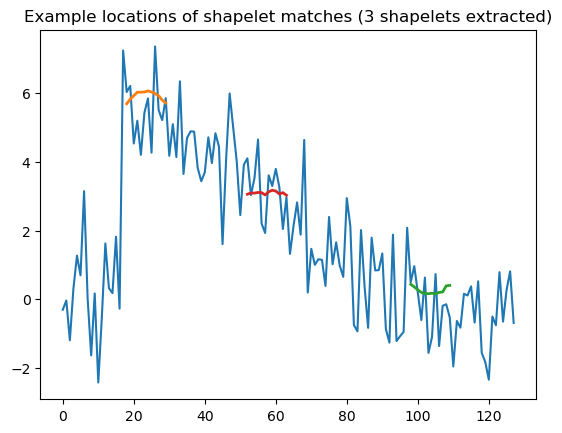

In [22]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title(f"""Example locations of shapelet matches ({n_shapelets} shapelets extracted)""")

plt.plot(X[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

### Another way of extracting shaplets

The Shapelet Transform algorithm extracts the most discriminative shapelets from a data set of time series. A shapelet is defined as a subset of consecutive points from a time series. Two criteria are made available: mutual information and F-scores.

In [23]:
from pyts.transformation import ShapeletTransform
st = ShapeletTransform(n_shapelets=5, window_sizes=[8])
st.fit(X, y)

ShapeletTransform(n_shapelets=5, window_sizes=[8])

In [24]:
len(st.shapelets_)

5

In [25]:
st.shapelets_

array([[2.98646757, 3.37317756, 3.56491409, 1.51560696, 2.71553641,
        3.37816335, 1.11274083, 3.4952731 ],
       [2.38649756, 3.14754881, 2.43499739, 2.68289928, 2.25221836,
        1.30229917, 3.57582743, 2.30220944],
       [3.86768091, 3.44254948, 1.97362051, 4.03209882, 4.69276688,
        2.65224013, 1.44202827, 2.40616013],
       [1.98968297, 4.36556417, 4.12494848, 1.97593873, 1.89793117,
        1.98066962, 1.99844116, 3.38858832],
       [5.26993205, 4.98310642, 1.93153851, 2.67752343, 3.55562448,
        2.71529886, 0.98846153, 2.14169181]])

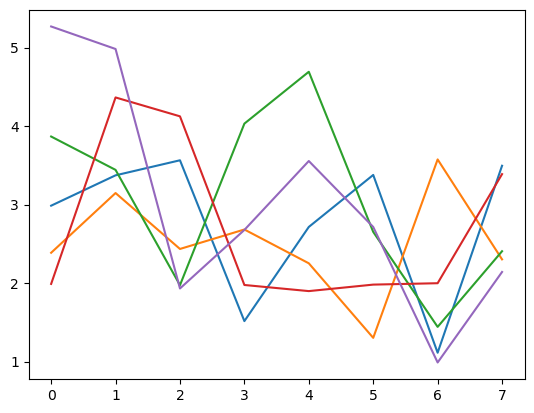

In [26]:
for s in st.shapelets_:
    plt.plot(s)

plt.show()

The indices for the corresponding shapelets in the training set. The first column consists of the indices of the samples. The second column consists of the starting indices (included) of the shapelets. The third column consists of the ending indices (excluded) of the shapelets.

In [36]:
st.indices_

array([[ 2, 56, 64],
       [ 6, 55, 63],
       [ 5, 60, 68],
       [ 2, 65, 73],
       [11, 66, 74]])

In [37]:
st.scores_

array([0.72282047, 0.73922258, 0.76154401, 0.77463925, 0.84408369])

### Shaplet + classification 


In [27]:
from pyts.classification import LearningShapelets
shp_clf = LearningShapelets(random_state=42, tol=0.01)

In [28]:
shp_clf.fit(X, y)

LearningShapelets(random_state=42, tol=0.01)

In [33]:
shp_clf.coef_.shape

(3, 78)

In [30]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0, 0], 
                        shp_clf.shapelets_[0, 1], 
                        shp_clf.shapelets_[0, 2]])

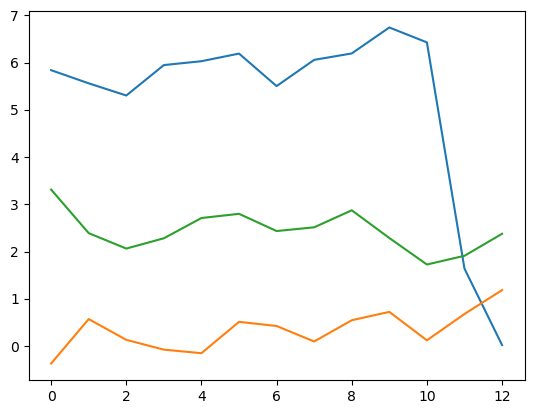

In [31]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])

plt.show()